In [192]:
import osqp
import cvxpy as cp
import numpy as np

import scipy as sp
from scipy import sparse

import matplotlib.pyplot as plt
from scipy.linalg import hankel

import gym
import mujoco_py
from gym import wrappers
from IPython import display
plt.rcParams["figure.figsize"] = (18,6)
%matplotlib inline

## Data Collection

In [193]:
env = gym.make('InvertedPendulum-v4', render_mode='rgb_array')
"""
    Timestep for InvertedPendelum-v4 is 0.02
"""
obs, info = env.reset()
# ud = np.array([0])
# yd = obs
# done = False
# start = True

Tini = 1
n = 4
N = 5
m = 1
p = 4
T = (m+1)*(Tini + N + n) - 1
print(T)
render_collection = False

ud = []
yd = []

for i in range(T):
    action = env.action_space.sample()
    # action = np.random.uniform(low=-0.5, high=0.5, size=(m,))
    obs, rew, done, info, _ = env.step(action)
    # if not start:
    #     obs = obs + np.random.uniform(low=-0.01, high=0.01, size=(p,))
    # start = False

    if render_collection:
        plt.title(f"Action {action[0]:.3f} Iter {i}")
        plt.imshow(env.render())
        display.display(plt.gcf())    
        display.clear_output(wait=True)

    ud = np.append(ud,action)
    yd = np.append(yd,obs)

env.close()
T = T
print(f'yd shape : {yd.shape}   ud shape : {ud.shape}')
print(yd)


19
yd shape : (76,)   ud shape : (19,)
[-1.56063477e-02  3.86417528e-02 -6.74999414e-01  1.56492103e+00
 -5.16904968e-02  1.21362163e-01 -1.12836321e+00  2.57016129e+00
 -1.14982576e-01  2.65206566e-01 -2.02960908e+00  4.59772953e+00
 -2.06679652e-01  4.72242527e-01 -2.54595445e+00  5.73653069e+00
 -3.22319416e-01  7.31186462e-01 -3.21509926e+00  7.15010138e+00
 -4.42126789e-01  1.00801392e+00 -2.77837975e+00  6.76350402e+00
 -5.41623384e-01  1.27419069e+00 -2.19821960e+00  6.62048964e+00
 -6.30479438e-01  1.54903357e+00 -2.23665098e+00  7.11610270e+00
 -7.04284641e-01  1.67910078e+00 -1.49048524e+00  2.31757662e-01
 -7.66329480e-01  1.65464342e+00 -1.60570306e+00 -9.66712066e-01
 -8.26425583e-01  1.61889745e+00 -1.39907729e+00 -7.47870799e-01
 -8.82606688e-01  1.59577944e+00 -1.41038650e+00 -4.21063026e-01
 -9.31825045e-01  1.58360362e+00 -1.05085284e+00 -2.08000394e-01
 -9.61895261e-01  1.57779006e+00 -4.52961879e-01 -9.57935263e-02
 -9.79331830e-01  1.57515906e+00 -4.18892900e-01 -4

In [194]:
ud

array([-2.04948163, -1.39320338, -2.79680967, -1.77060688, -2.54117084,
        1.01564968,  1.59156024, -0.8415764 ,  2.79537511, -0.42164084,
        0.76808035, -0.06762052,  1.37695014,  2.30707884,  0.12736188,
        2.29190516,  0.79900885,  1.71111047,  0.07628933])

In [195]:
L = Tini + N + n
H = hankel(ud[0:L], ud[L-1:])
print(f'H has rank {np.linalg.matrix_rank(H)} and shape {H.shape}')

H has rank 10 and shape (10, 10)


In [196]:
L = Tini + N

U = hankel(ud[0:L], ud[L-1:])

Y = np.zeros((L*p, T-L+1))
for i in range(0,T-L+1):
    Y[:,i] = yd[p*i:p*(L+i)]

Up = U[0:Tini, :]
Uf = U[Tini:, :]
print(f'U = {U.shape}, Up = {Up.shape}, Uf = {Uf.shape}')

Yp = Y[0:p*Tini, :]
Yf = Y[p*Tini:, :]
print(f'Y = {Y.shape}, Yp = {Yp.shape}, Yf = {Yf.shape}')

u_ini = ud[:Tini]
y_ini = yd[:p*Tini]
print(f'u ini : {u_ini}\ny ini : {y_ini}')


U = (6, 14), Up = (1, 14), Uf = (5, 14)
Y = (24, 14), Yp = (4, 14), Yf = (20, 14)
u ini : [-2.04948163]
y ini : [-0.01560635  0.03864175 -0.67499941  1.56492103]


## Solver

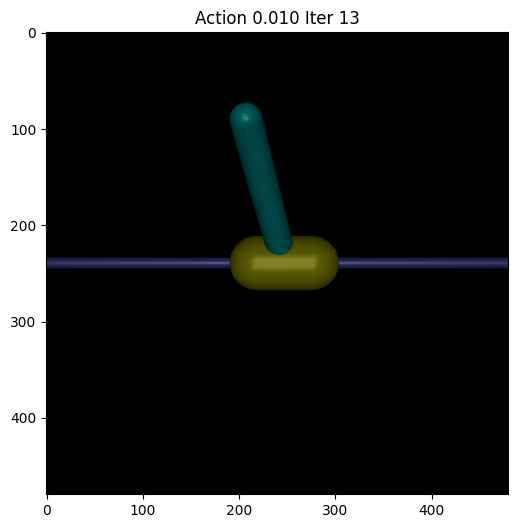

In [197]:
g = cp.Variable(T - Tini - N + 1)
u = cp.Variable(N)
y = cp.Variable(N*p)
# sig_y = cp.Variable(p*Tini)

Q = np.diag([1,100,1,1])
Q = np.kron(np.eye(N), Q)
R = np.eye(N)

cost = cp.quad_form(y, Q) + cp.quad_form(u,R) + cp.norm(g,1) #+ cp.norm(sig_y, 1)*10000

env = gym.make('InvertedPendulum-v4', render_mode='rgb_array')
env._max_episode_steps = 100
obs = env.reset()
yT = [*y_ini]
uT = [*u_ini]
done = False
iter = 0
render_solution = True

while not done:

  constraints = [
    Up @ g == u_ini,
    Yp @ g == y_ini,# + sig_y,
    Uf @ g == u,
    Yf @ g == y,
    cp.abs(u) <= 3
  ]

  prob = cp.Problem(cp.Minimize(cost), constraints)
  prob.solve(solver=cp.ECOS, verbose=False)
  action = prob.variables()[1].value[0]

  if render_solution:
    plt.title(f"Action {action:.3f} Iter {iter}")
    plt.imshow(env.render())
    display.display(plt.gcf())    
    display.clear_output(wait=True)
  
  obs,_,done,_,_ = env.step([action])
  # obs = obs + np.random.uniform(low=-0.01, high=0.01, size=(p,))
  yT = np.append(yT, obs)
  uT = np.append(uT, action)
    
  u_ini = uT[-Tini:]
  y_ini = yT[-p*Tini:]
  iter += 1

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


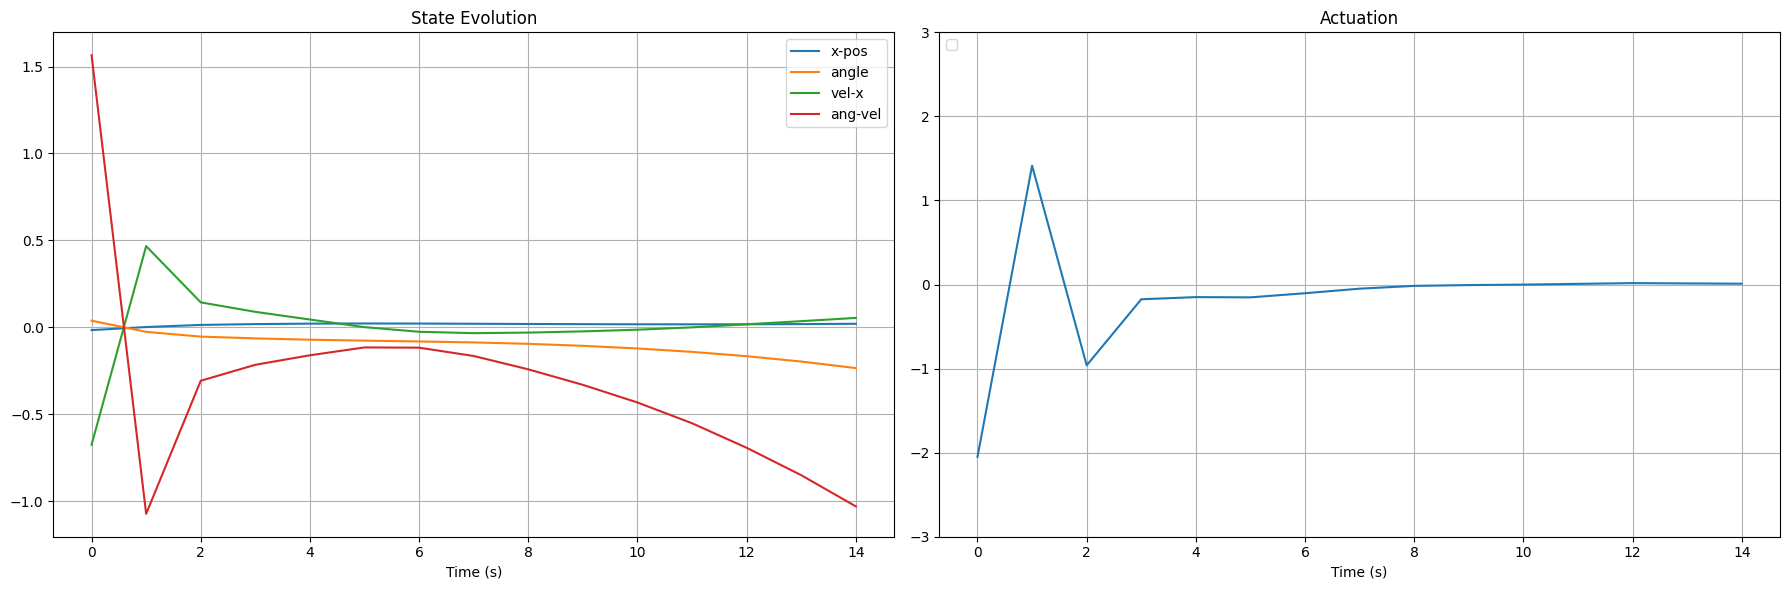

In [198]:
T = len(uT)
yT = yT.reshape((T,4))

plt.subplot(1,2,1)
plt.plot(range(0,T), yT, label=['x-pos', 'angle', 'vel-x', 'ang-vel'])
plt.legend(loc="upper right")
plt.xlabel('Time (s)')
plt.title("State Evolution")
plt.grid('on')
plt.tight_layout()

plt.subplot(1,2,2)
plt.plot(range(0,T), uT)
plt.legend(loc="upper left")
plt.xlabel('Time (s)')
plt.title("Actuation")
plt.ylim((-3,3))
plt.grid('on')
plt.tight_layout()

plt.show()